In [1]:
import pandas as pd

import numpy as np
import os, sys

# pvlib imports
import pvlib

from pvlib.pvsystem import PVSystem

from pvlib.location import Location

from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

from timeseries_functions import timeseries_plotter, timesteplen_calculator, cleaner_per_day, remove_duplicate_index
from dtw import *

import plotly.express as px
import seaborn as sns
import h5py



Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:


def physical_profile(row):

    "Pass a dataset for PV Meta Data: Location, Tilt, Azimuth, Capacity and a Dataset for irradiance: DNI, DHI, GHI to calculate profiles with PV Watts"
    
    index, latitude, longitude, tilt, azimuth, capacity = row

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    location = Location(latitude=latitude, longitude=longitude)

    pvwatts_system = PVSystem(surface_tilt= tilt , surface_azimuth=azimuth,
        module_parameters={'pdc0': capacity, 'gamma_pdc': -0.004},
        inverter_parameters={'pdc0': capacity},
        temperature_model_parameters=temperature_model_parameters)
    
    mc = ModelChain(pvwatts_system, location, aoi_model='physical', spectral_model='no_loss')
    mc.run_model(df_irr)
    results = mc.results.ac

    df_results = pd.Series(results)
    df_results.index = df_results.index.tz_localize(None)
    df_results.index.name = "timestamp"

    return df_results

In [5]:
os.getcwd()

'/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Research/Paper_2_Collaborative Forecasting/Code/Collaborative_PV_Forecasting'

# Data Imports

In [3]:
df_power = pd.read_csv("../../Input_Data/PV_System_Power.csv", index_col=0, parse_dates=True)

In [4]:
original_timesteplen = round(timesteplen_calculator(df_power),10)
original_timestep = round(original_timesteplen/10)*10
first_timestep = df_power.index[0]
last_timestep = df_power.index[-1]
selected_systems= df_power.columns
target_timesteplen = "15T"


In [5]:
df_power = df_power.resample(target_timesteplen).mean()

In [6]:
df_power.columns = [int(col) for col in df_power.columns]

In [8]:
df_meta = pd.read_csv("../../Data/System/PV system information dataset TU WIEN.csv", sep = ";", index_col=0)
df_meta = df_meta.iloc[:,1:]
df_meta["tilt"] = df_meta["tilt"].str.replace(",",".")
df_meta["azimuth"] = df_meta["azimuth"].str.replace(",",".")
df_meta = df_meta.astype("float")
total_cap = df_meta["estimated capacity"].sum() / 10**6


In [9]:

selected_systems = [int(index) for index in selected_systems]
df_meta = df_meta.loc[selected_systems,:]

In [10]:
df_irr = pd.read_csv("../../Data/Meteo/GHI_DNI_DHI.csv", index_col=0, parse_dates=True)
df_irr = df_irr.iloc[:,2:]
print(df_irr.columns)
df_irr.columns = ["dhi", "dni", "ghi"]
df_irr = df_irr.resample(target_timesteplen).mean()
df_irr = df_irr.tz_localize(None)
df_irr = df_irr[first_timestep:last_timestep]

Index(['Dhi', 'Dni', 'Ghi'], dtype='object')


In [11]:
def entsoe_data_manipulation(df, technology= "Price"): #ist ausbaufähig ;) 

    index_name = df.index.name

    cols = [string for string in df.columns if technology in string] 
    df = df[cols].reset_index()
    df[["timestamp"]] = df[index_name].str.split("-", expand= True)[0]
    df.index = pd.DatetimeIndex(df["timestamp"])
    df = df.drop([index_name, "timestamp"], axis = 1)
    return df

df_price_2015 = pd.read_csv("../../Data/Price/Imbalance_201501010000-201601010000.csv", index_col=0)
df_price_2016 = pd.read_csv("../../Data/Price/Imbalance_201601010000-201701010000.csv", index_col=0)
df_price_2015 = entsoe_data_manipulation(df_price_2015, "Price")
df_price_2016 = entsoe_data_manipulation(df_price_2016, "Price")
df_price = pd.concat([df_price_2015, df_price_2016],axis = 0)
df_price.columns = [col[0] for col in df_price.columns]
df_price = remove_duplicate_index(df_price, df_price.index.name)

# Best Case (Full Information)

In [85]:
df_full_info = df_meta.reset_index().apply(physical_profile, axis=1).transpose()
df_full_info.columns = df_meta.index

In [86]:
def error_calc(df_phys, df_measured, timesteplen, unit= "W"):

    "Input physical and measured timeseries of PV in Watts"
    
    df_copy = df_phys.copy()
    for column in df_phys:
        df_copy[column] -= df_measured[column]
   
    df_copy.dropna(inplace=True)

    df_errors_per_system = abs(df_copy).sum(0)

    df_errors_total = df_copy.sum(axis=1)

    if unit == "W":
        df_errors_total = pd.DataFrame(df_errors_total, columns=["error"])
        df_errors_total *= (60/int(timesteplen[:-1])) #from W to Wh
        df_errors_total /= 10**6 #from Wh to MWh
    else:
        raise ValueError("unit should be in Watts")

    return df_errors_total, df_errors_per_system

In [87]:
df_errors_total, df_errors_per_system = error_calc(df_full_info, df_power, target_timesteplen)

df_errors_per_system_total_information = pd.DataFrame(df_errors_per_system, columns=["total info"])

In [58]:
fig = px.line(df_errors_total)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [104]:
df_errors_total

,error
timestamp,
2015-01-01 00:00:00,0.0
2015-01-01 00:15:00,0.0
2015-01-01 00:30:00,0.0
2015-01-01 00:45:00,0.0
2015-01-01 01:00:00,0.0
...,...
2015-12-23 22:45:00,0.0
2015-12-23 23:00:00,0.0
2015-12-23 23:15:00,0.0


In [106]:
def economic_cost_calculator(df_price, df_errors, total_cap):


    df_merged = pd.merge(df_price, abs(df_errors), left_index=True, right_index=True)

    df_merged["cost"] = df_merged["+"] * df_merged["error"]
    #df_merged_pos = df_merged.loc[df_merged["error"] > 0][["error", "+"]].apply(np.prod, axis = 1)
    #df_cost_pos = pd.DataFrame(df_merged_pos, columns=["cost"])
    #df_merged_neg = df_merged.loc[df_merged["error"] < 0][["error", "-"]].apply(np.prod, axis = 1) *-1
    #df_cost_neg = pd.DataFrame(df_merged_neg, columns=["cost"])
    #df_cost = pd.concat([df_cost_pos, df_cost_neg], axis = 0).reindex(df_merged.index).dropna()

    df_cost = df_merged[["cost"]]
    
    total_cost = (df_cost.sum(axis = 0) / total_cap)

    print("The total cost is {0} €/(MWp*a)".format(total_cost))

    return df_merged, df_cost, total_cost

In [107]:
df_merged, df_cost_full_info, total_cost = economic_cost_calculator(df_price, df_errors_total, total_cap)

The total cost is cost    73102.275937
dtype: float64 €/(MWp*a)


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_merged[df_merged.columns] = scaler.fit_transform(df_merged[df_merged.columns])

# Case A (No Tilt)

Have to find the right tilt and azimuths with the script

### Checking if Tilt makes a difference

We see that the tilt is more or less uniformly distributed

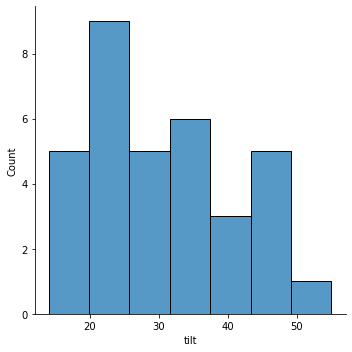

In [302]:
sns.displot(df_meta["tilt"])


Tilt has a major impact on the physical modelling

In [34]:
row_1

latitude               52.072803
longitude               5.133646
tilt                   88.000000
azimuth               185.000000
estimated capacity    919.781681
Name: 487, dtype: float64

In [54]:
system_id = 487
row_1 = df_meta.loc[system_id,:]
row_2 = df_meta.loc[system_id,:]
print(row_1)

row_2["tilt"] = 88
row1 = row_1.reset_index().apply(physical_profile,axis= 1).transpose()
row2 = row_2.reset_index().apply(physical_profile,axis= 1).transpose()
df_compare = pd.concat([row1, row2, df_power[system_id]], axis = 1)
df_compare.columns = ["tilt 25", "tilt 88", "real"]
fig = px.line(df_compare)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

latitude               52.072803
longitude               5.133646
tilt                   88.000000
azimuth               185.000000
estimated capacity    919.781681
Name: 487, dtype: float64


ValueError: not enough values to unpack (expected 6, got 2)

In [326]:
df_test = pd.DataFrame(df_power[281])
df_test.columns = ["281"]
row1.columns = ["281"]

### Cost Calculation

In [99]:
num_of_systems = df_meta.shape[0]
tilt_batches = 1000
tilts = np.random.uniform(5,90, (num_of_systems*tilt_batches,1))

In [111]:
df_meta_tilts = df_meta.copy()

costs = []

for i in range(tilt_batches):
    df_meta_tilts["tilt"] = tilts[i:i+num_of_systems]
    print(df_meta_tilts["tilt"].mean())
    df_phys = df_meta_tilts.reset_index().apply(physical_profile, axis=1).transpose()
    df_phys.columns = df_meta_tilts.index
    df_errors, df_errors_per = error_calc(df_phys, df_power, target_timesteplen)
    merged,_, total_cost = economic_cost_calculator(df_price, df_errors, total_cap)

    costs.append(np.squeeze(total_cost))

49.643548548210994
The total cost is cost    63600.274418
dtype: float64 €/(MWp*a)
50.01106338767153


KeyboardInterrupt: 

In [113]:
costs

[63600.27441762501]

# Case B (No Azimuth)

In [242]:
np.random.seed(0)

azimuths = np.random.uniform(0,360, (1000,1))


# Case C (No Azimuth and Tilt)